This is an exploratory notes page for the final projects. It will be split into three parts, for each dataset we are presented.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Part I: Customer Churn

We will first look at the customer churn dataset, `./data/Customer_Churn_Dataset.csv`.

In [2]:
customer_churn_fn = './data/Customer_Churn_Dataset.csv'
cc_raw = pd.read_csv(customer_churn_fn)
cc_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [3]:
cc_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Simply looking at the features and data types, there's a lot we need to do to this data. For instance, let's try to further examine these mysterious `object` type features.

In [4]:
print(type(cc_raw['PaymentMethod'][3]))
print(cc_raw['Contract'].unique())
print(len(cc_raw['customerID']))

<class 'str'>
['Month-to-month' 'One year' 'Two year']
7043


Since each of these are strings, we should create a function that takes a `pandas.Series` of strings and appends a one-hot-encoded dataframe of that feature to a new dataframe. Then, we'll loop through each of the features and create a new `pandas.DataFrame` object to contain the one-hot encoded features.

In [5]:
# data cleaning

cc_raw = cc_raw.drop('customerID', axis = 1) # drop customer IDs feature
cc_raw['TotalCharges'] = pd.to_numeric(cc_raw['TotalCharges'], errors = 'coerce') # make string float numeric

# this one-hot encoding solution is inspired by Cybernetic's solution here:
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

cc = pd.DataFrame()
exempt_features = ['tenure', 'Churn', 'MonthlyCharges', 'TotalCharges']

def encode(feature, label):
    global cc
    new_feats = pd.get_dummies(feature, prefix = label, drop_first = True)
    cc = pd.concat([cc, new_feats], axis = 1)

# one-hot encode categorical features    
for i in range(len(cc_raw.columns)):
    col_name = cc_raw.columns[i]
    if col_name not in exempt_features:
        encode(cc_raw[col_name], col_name)

cc = pd.concat([cc, cc_raw[['tenure', 'MonthlyCharges', 'TotalCharges']]], axis = 1)
encode(cc_raw['Churn'], 'Churn')
cc = cc.dropna()

cc.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn_Yes
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,1,29.85,29.85,0
1,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,34,56.95,1889.50,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,2,53.85,108.15,1
3,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,45,42.30,1840.75,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,2,70.70,151.65,1


In [6]:
X1 = cc.drop('Churn_Yes', axis = 1)
X1 = sm.add_constant(X1)
y = cc['Churn_Yes']

model_1 = sm.OLS(y, X1)
model_1_fit = model_1.fit()
p_values = model_1_fit.pvalues
useful_columns = list(p_values[p_values <= 0.05].index)
print(useful_columns)
model_1_fit.summary()

['const', 'SeniorCitizen_1', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'tenure', 'TotalCharges']


d:\python 3.7\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Churn_Yes   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     120.9
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:27:50   Log-Likelihood:                -3057.9
No. Observations:                7032   AIC:                             6164.
Df Residuals:                    7008   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2737      0.103      2.658      0.008       0.072       0.476
gender_Male                              -0.0034      0.009     -0.375      0.707      -0.021       0.014
SeniorCitizen_1                           0.0445      0.013      3.419      0.001       0.019       0.070
Partner_Yes                              -0.0009      0.011     -0.079      0.937      -0.022       0.020
Dependents_Yes                           -0.0202      0.011     -1.766      0.078      -0.043       0.002
PhoneService_Yes                          0.1341      0.095      1.408      0.159      -0.053       0.321
MultipleLines_No phone service            0.1396      0.014      9.679      0.000       0.111       0.168
MultipleLines_Yes                         0.0587      0.024      2.403      0.016       0.011       0.107
InternetService_Fiber optic               0.2104      0.110      1.920      0.055      -0.004       0.425
InternetService_No                       -0.0256      0.016     -1.621      0.105      -0.057       0.005
OnlineSecurity_No internet service       -0.0256      0.016     -1.621      0.105      -0.057       0.005
OnlineSecurity_Yes                       -0.0425      0.025     -1.710      0.087      -0.091       0.006
OnlineBackup_No internet service         -0.0256      0.016     -1.621      0.105      -0.057       0.005
OnlineBackup_Yes                         -0.0113      0.024     -0.462      0.644      -0.059       0.037
DeviceProtection_No internet service     -0.0256      0.016     -1.621      0.105      -0.057       0.005
DeviceProtection_Yes                      0.0046      0.025      0.185      0.853      -0.044       0.053
TechSupport_No internet service          -0.0256      0.016     -1.621      0.105      -0.057       0.005
TechSupport_Yes                          -0.0439      0.025     -1.754      0.079      -0.093       0.005
StreamingTV_No internet service          -0.0256      0.016     -1.621      0.105      -0.057       0.005
StreamingTV_Yes                           0.0638      0.045      1.416      0.157      -0.025       0.152
StreamingMovies_No internet service      -0.0256      0.016     -1.621      0.105      -0.057       0.005
StreamingMovies_Yes                       0.0658      0.045      1.460      0.144      -0.023       0.154
Contract_One year                        -0.1056      0.014     -7.549      0.000      -0.133      -0.078
Contract_Two year                        -0.0700      0.017     -4.110      0.000      -0.103      -0.037
PaperlessBilling_Yes                      0.0449      0.010      4.495      0.000       0.025       0.064
PaymentMethod_Credit card (automatic)    -0.0061      0.014     -0.448      0.654      -0.033       0.020
PaymentMe

In [7]:
useful_columns.remove('const')
X2 = cc[useful_columns]
model_2 = sm.OLS(y, X2)
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Churn_Yes   R-squared (uncentered):                 -14.322
Model:                            OLS   Adj. R-squared (uncentered):            -14.342
Method:                 Least Squares   F-statistic:                             -729.4
Date:                Mon, 25 Nov 2019   Prob (F-statistic):                        1.00
Time:                        13:27:50   Log-Likelihood:                         -3701.4
No. Observations:                7032   AIC:                                      7421.
Df Residuals:                    7023   BIC:                                      7483.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
SeniorCitizen_1                    0.1181      0.014      8.583      0.000       0.091       0.145
MultipleLines_No phone service     0.1070      0.017      6.197      0.000       0.073       0.141
MultipleLines_Yes                  0.1438      0.012     12.394      0.000       0.121       0.167
Contract_One year                 -0.0654      0.014     -4.551      0.000      -0.094      -0.037
Contract_Two year                 -0.0808      0.017     -4.684      0.000      -0.115      -0.047
PaperlessBilling_Yes               0.2279      0.009     24.145      0.000       0.209       0.246
PaymentMethod_Electronic check     0.2503      0.011     23.635      0.000       0.230       0.271
tenure                            -0.0009      0.000     -2.159      0.031      -0.002    -8.4e-05
TotalCharges                   -1.718e-05   4.19e-06     -4.100      0.000   -2.54e-05   -8.97e-06
==============================================================================
Omnibus:                      430.562   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              480.726
Skew:                           0.618   Prob(JB):                    4.09e-105
Kurtosis:                       2.663   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

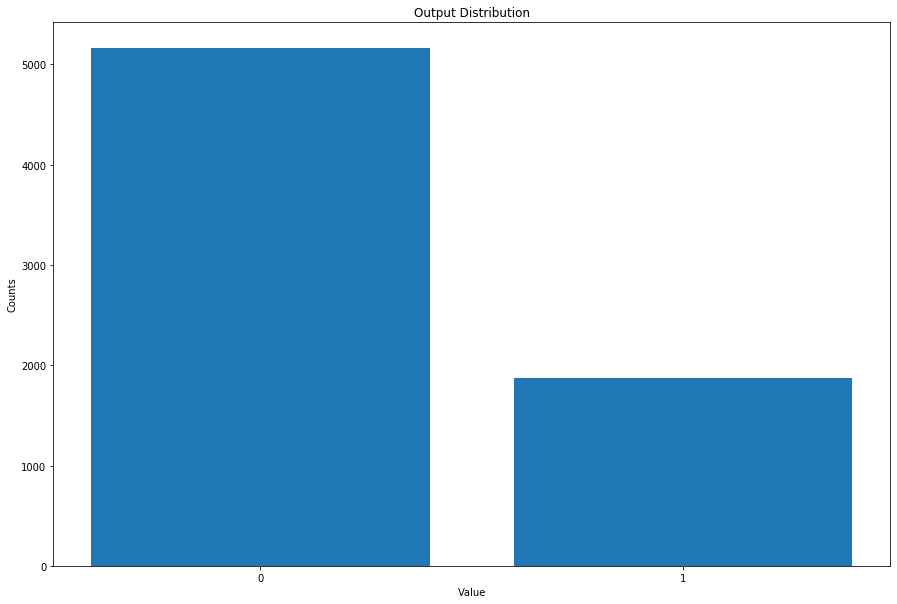

In [8]:
output_plot = plt.figure(figsize = (15, 10))
output_axis = output_plot.add_subplot(111)
output_axis.bar(y.unique(), y.value_counts())
output_axis.title.set_text('Output Distribution')
output_axis.set_xlabel('Value')
output_axis.set_ylabel('Counts')
output_axis.set_xticks(y.unique())
#output_axis.plot(model_1.predict(X1), label = 'Prediction 1')
#output_axis.plot(model_2.predict(X2), label = 'Prediction 2')
plt.show()

In [12]:
cor = pd.concat([X2, y], axis = 1).corr()
cor.style.background_gradient(cmap = 'RdBu_r', axis = None).set_precision(2)

,SeniorCitizen_1,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,tenure,TotalCharges,Churn_Yes
SeniorCitizen_1,1,-0.0084,0.14,-0.046,-0.12,0.16,0.17,0.016,0.1,0.15
MultipleLines_No phone service,-0.0084,1,-0.28,0.0031,-0.0044,-0.017,-0.0027,-0.0079,-0.11,-0.012
MultipleLines_Yes,0.14,-0.28,1,-0.0036,0.11,0.16,0.084,0.33,0.47,0.04
Contract_One year,-0.046,0.0031,-0.0036,1,-0.29,-0.052,-0.11,0.2,0.17,-0.18
Contract_Two year,-0.12,-0.0044,0.11,-0.29,1,-0.15,-0.28,0.56,0.36,-0.3
PaperlessBilling_Yes,0.16,-0.017,0.16,-0.052,-0.15,1,0.21,0.0048,0.16,0.19
PaymentMethod_Electronic check,0.17,-0.0027,0.084,-0.11,-0.28,0.21,1,-0.21,-0.06,0.3
tenure,0.016,-0.0079,0.33,0.2,0.56,0.0048,-0.21,1,0.83,-0.35
TotalCharges,0.1,-0.11,0.47,0.17,0.36,0.16,-0.06,0.83,1,-0.2
Churn_Yes,0.15,-0.012,0.04,-0.18,-0.3,0.19,0.3,-0.35,-0.2,1
